In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.max_columns', None)

import sys
import os
sys.path.append(os.path.abspath("/home/lideyi/AKI_GNN/notebooks/utils"))
from common_var import raw_path, ct_names, pat_id_cols, race_mapping
from read_dfs import get_data_path, concat_dfs_to_one, read_and_format_SCR, \
    read_and_format_DX, read_and_format_DEMO, dup_check

# Read Patient ID Dataframe

In [2]:
def read_onsets(ct_names: list, raw_path: str) -> dict:
    onset_dict = dict()
    use_cols = ["PATID", "ENCOUNTERID", "ADMIT_DATE", "DISCHARGE_DATE"]
    
    for ct_name in ct_names:

        data_path = get_data_path(ct_name, raw_path)
            
        if (ct_name == 'UPITT') or (ct_name == 'UTHSCSA') or (ct_name == 'UIOWA'):
            onset_df = pd.read_csv(data_path + "AKI_ONSETS.csv", delimiter = ',', usecols = use_cols)
            
        elif (ct_name == 'UTSW'):
            onset_df = pd.read_csv(data_path + "AKI_ONSETS.dsv", delimiter = '|', usecols = use_cols)
            
        elif (ct_name == 'MCW'):
            onset_df = pd.read_csv(data_path + "AKI_ONSETS.dsv", delimiter = '|')
            onset_df.columns = [col.upper() for col in onset_df.columns] 
            onset_df = onset_df[use_cols]
            
        elif (ct_name == 'UMHC'):
            onset_df = pd.read_csv(data_path + "DEID_AKI_ONSETS.csv", delimiter = ',', usecols = use_cols)
            
        elif (ct_name == 'UofU'):
            onset_df = pd.read_csv(data_path + "AKI_ONSETS.csv", delimiter = '|', usecols = use_cols)
            
        elif (ct_name == 'KUMC'):
            onset_df = pd.read_csv(data_path + "AKI_ONSETS.csv", delimiter = ',')
            onset_cols = onset_df.columns.tolist()
            onset_cols = [s[:-len('"+PD.DATE_SHIFT"')] if s.endswith('"+PD.DATE_SHIFT"') else s for s in onset_cols]
            onset_df.columns = onset_cols
            onset_df = onset_df[use_cols]
            
        onset_dict[ct_name] = onset_df

    return onset_dict

In [3]:
def format_onest_dict(onset_dict: dict) -> dict:
    processed_onset_dict = dict()
    for ct_name, onset_df in onset_dict.items():    
        #convert id columns to string
        onset_df['PATID'] = onset_df['PATID'].astype(str)
        onset_df['ENCOUNTERID'] = onset_df['ENCOUNTERID'].astype(str)
        onset_df.rename(columns={'ENCOUNTERID': 'ONSETS_ENCOUNTERID'}, inplace = True) 
        
        # Converting string data type into datetime object
        onset_df['ADMIT_DATE'] = pd.to_datetime(onset_df['ADMIT_DATE'], format='mixed')
        onset_df['DISCHARGE_DATE'] = pd.to_datetime(onset_df['DISCHARGE_DATE'], format='mixed')
        
        onset_df['CENTER_NAME'] = ct_name
        processed_onset_dict[ct_name] = onset_df
    return processed_onset_dict

In [4]:
def read_and_format_onsets(ct_names: list, raw_path: str) -> pd.DataFrame:
    print("Read patient ID dfs:")
    onset_dict = read_onsets(ct_names, raw_path)
    processed_onset_dict = format_onest_dict(onset_dict)
    
    for ct_name, onset_df in processed_onset_dict.items():
        print("%s: %s" %(ct_name, len(onset_df.ONSETS_ENCOUNTERID)))
        
    onset_df = concat_dfs_to_one(processed_onset_dict)
    return onset_df

In [5]:
onset_df = read_and_format_onsets(ct_names, raw_path)
# drop duplicates based on pat_id_cols
onset_df = onset_df.drop_duplicates(subset = pat_id_cols)
dup_check(onset_df, pat_id_cols)

Read patient ID dfs:
KUMC: 268640
UPITT: 598634
# of rows before dropping dups:  865871
# of rows after dropping dups:  865871


# Read SCr Measurement Dataframe

In [6]:
SCR_df = read_and_format_SCR(ct_names, raw_path)

100%|██████████| 2/2 [05:11<00:00, 155.54s/it]


# Merge Patient ID with SCr Measurement

In [7]:
# important: here we do not merge on encounter id, that is each encounter of each patient will be matched to
# all SCr measurements this patient had, later on we will cut the measurement by time
SCr_complete_df = onset_df.merge(SCR_df[['CENTER_NAME', 'PATID', 'SPECIMEN_DATE', 'RESULT_NUM']], 
                             on = ['CENTER_NAME', 'PATID'], how = 'left')

In [8]:
#we maintain a final df here, without any dups
onset_df_final = onset_df.copy(deep = True)
dup_check(onset_df_final, pat_id_cols)

# of rows before dropping dups:  865871
# of rows after dropping dups:  865871


# Compute SCr Baseline

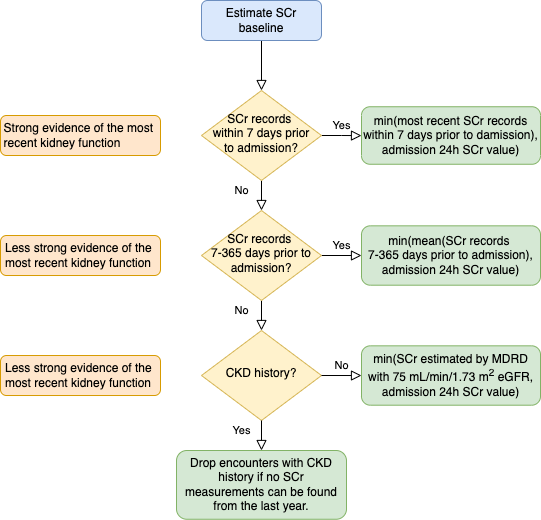

In [9]:
from IPython.display import Image
Image(filename='SCr_baseline_est.png')

In [10]:
# SCr within 24 hour after admission, that is admission day and one day after, get mean
# first we select SCr measurements based on date
admission_SCr = SCr_complete_df[(SCr_complete_df.SPECIMEN_DATE >= SCr_complete_df.ADMIT_DATE) & \
                            (SCr_complete_df.SPECIMEN_DATE <= (SCr_complete_df.ADMIT_DATE + pd.Timedelta(days=1)))].copy()
# here we take the mean at the encounter level
admission_SCr = admission_SCr.groupby(pat_id_cols)['RESULT_NUM'].mean().reset_index()
# create a new column recoding the admission SCr level
admission_SCr.rename(columns = {"RESULT_NUM": "ADMISSION_SCR"}, inplace = True)
# merge the ADMISSION_SCR back to the main frame
onset_df_final = onset_df_final.merge(admission_SCr, on = pat_id_cols, how = "left")

In [11]:
dup_check(onset_df_final, pat_id_cols)

# of rows before dropping dups:  865871
# of rows after dropping dups:  865871


In [12]:
# how many encounters do not have admission SCr level?
print(onset_df_final.ADMISSION_SCR.isna().mean())

0.06804708784564906


# Step 1: 7-day SCr Level Pior to Admission

In [13]:
#SCr within 7 days prior to admission
one_week_prior_admission = SCr_complete_df[(SCr_complete_df.SPECIMEN_DATE >= SCr_complete_df.ADMIT_DATE - pd.Timedelta(days=7)) & \
                                 (SCr_complete_df.SPECIMEN_DATE < SCr_complete_df.ADMIT_DATE)].copy()

In [14]:
# sort based on speciment date and group and take the last record as the representative
one_week_prior_admission = one_week_prior_admission.sort_values(by = pat_id_cols + ["SPECIMEN_DATE"], ascending = True)
one_week_prior_admission = one_week_prior_admission.groupby(pat_id_cols)['RESULT_NUM'].last().reset_index()

In [15]:
one_week_prior_admission.rename(columns = {"RESULT_NUM": "ONE_WEEK_SCR"}, inplace = True)
onset_df_final = onset_df_final.merge(one_week_prior_admission, on = pat_id_cols, how = "left")

In [16]:
dup_check(onset_df_final, pat_id_cols)

# of rows before dropping dups:  865871
# of rows after dropping dups:  865871


In [17]:
# how many encounters do not have 7-day prior SCr level?
print(onset_df_final.ONE_WEEK_SCR.isna().mean())

0.7447633654435822


# Step 2: 365-day SCr Level Prior to Admission

In [18]:
# SCr within 7 days - 365 days prior to admission
one_year_prior_admission = SCr_complete_df[(SCr_complete_df.SPECIMEN_DATE >= SCr_complete_df.ADMIT_DATE - pd.Timedelta(days=365)) & \
    (SCr_complete_df.SPECIMEN_DATE < SCr_complete_df.ADMIT_DATE- pd.Timedelta(days=7))].copy()
# 7 - 365 day SCr records mean
one_year_prior_admission = one_year_prior_admission.groupby(pat_id_cols)['RESULT_NUM'].mean().reset_index()
# rename the column before merging
one_year_prior_admission.rename(columns = {"RESULT_NUM": "ONE_YEAR_SCR"}, inplace = True)
# merge
onset_df_final = onset_df_final.merge(one_year_prior_admission, on = pat_id_cols, how = "left")

In [19]:
dup_check(onset_df_final, pat_id_cols)

# of rows before dropping dups:  865871
# of rows after dropping dups:  865871


In [20]:
# how many encoutners do not have one year SCr level?
print(onset_df_final.ONE_YEAR_SCR.isna().mean())

0.32361171583295895


# Compute SCr Baseline Based on Step 1 and 2

In [21]:
# _RECORD means that the baseline is estaimated from history records, not imputed by MDRD
onset_df_final['BASELINE_SCR_RECORD'] = np.nan

# If ONE_WEEK_SCR is not null, return the smaller value between ONE_WEEK_SCR and ADMISSION_SCR (if ADMISSION_SCR is null, directly return ONE_WEEK_SCR).
onset_df_final.loc[onset_df_final.ONE_WEEK_SCR.notna(), 'BASELINE_SCR_RECORD'] = \
    onset_df_final[['ONE_WEEK_SCR', 'ADMISSION_SCR']].min(axis=1, skipna=True)
    
# If ONE_WEEK_SCR is null but ONE_YEAR_SCR is not null, return the smaller value between ONE_YEAR_SCR and ADMISSION_SCR (if ADMISSION_SCR is null, directly return ONE_YEAR_SCR).
onset_df_final.loc[((onset_df_final.ONE_WEEK_SCR.isna()) & (onset_df_final.ONE_YEAR_SCR.notna())), 'BASELINE_SCR_RECORD'] = \
    onset_df_final[['ONE_YEAR_SCR', 'ADMISSION_SCR']].min(axis=1, skipna=True)
    
# If both ONE_WEEK_SCR and ONE_YEAR_SCR are null, then directly return null. No code needed here. 

In [22]:
dup_check(onset_df_final, pat_id_cols)

# of rows before dropping dups:  865871
# of rows after dropping dups:  865871


In [23]:
# After step 1 and 2, how many encoutners do not have SCr baseline?
print(onset_df_final.BASELINE_SCR_RECORD.isna().mean())

0.28198888749016887


# Step 3: Estimate SCR Baseline for Encounters without Any History Records with MDRD

In [24]:
enc_to_MDRD = onset_df_final.loc[onset_df_final.BASELINE_SCR_RECORD.isna(), 
                                 pat_id_cols + ["ADMIT_DATE", "ADMISSION_SCR"]].copy(deep = True)

In [25]:
# please note that here enc_to_MDRD_DX is already history comorbidities, so we do not need to merge it here.
# we have this DX_date < ADMIT_DATE controlled in format_DX
enc_to_MDRD_DX = read_and_format_DX(ct_names, raw_path, enc_to_MDRD)

  0%|          | 0/2 [00:00<?, ?it/s]/home/lideyi/AKI_GNN/notebooks/utils/read_dfs.py:159: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  DX_df = pd.read_csv(data_path + "AKI_DX.csv", delimiter = ',')
 50%|█████     | 1/2 [00:39<00:39, 39.77s/it]/home/lideyi/AKI_GNN/notebooks/utils/read_dfs.py:137: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  DX_df = pd.read_csv(data_path + "AKI_DX.csv", delimiter = ',', usecols=use_cols)
100%|██████████| 2/2 [00:38<00:00, 19.21s/it]


In [26]:
# encounters with CKD without any history records
ICD9_CKD = ["585.1", "585.2", "585.3", "585.4", "585.5", "585.6"]
ICD10_CKD = ["N18.1", "N18.2", "N18.3", "N18.4", "N18.5", "N18.6"]
enc_to_MDRD_CKD = enc_to_MDRD_DX[((enc_to_MDRD_DX.DX.isin(ICD9_CKD)) & (enc_to_MDRD_DX.DX_TYPE == '9')) | \
              ((enc_to_MDRD_DX.DX.isin(ICD10_CKD)) & (enc_to_MDRD_DX.DX_TYPE == '10'))].copy()

In [27]:
# how many encounters with prior CKD history but without any SCr measurements? we drop them
print(len(enc_to_MDRD_CKD.ONSETS_ENCOUNTERID.unique())/len(onset_df_final))

0.004140339611789747


In [28]:
# unique encoutners to drop
CKD_enc_drop = enc_to_MDRD_CKD.drop_duplicates(subset=pat_id_cols)
# drop corresponding rows in onset_df_final and enc_to_MDRD
onset_df_final_merged = onset_df_final.merge(CKD_enc_drop[pat_id_cols], on=pat_id_cols, how='left', indicator=True)
onset_df_final = onset_df_final_merged[onset_df_final_merged['_merge'] == 'left_only'].drop(columns=['_merge'])
enc_to_MDRD_merged = enc_to_MDRD.merge(CKD_enc_drop[pat_id_cols], on=pat_id_cols, how='left', indicator=True)
enc_to_MDRD = enc_to_MDRD_merged[enc_to_MDRD_merged['_merge'] == 'left_only'].drop(columns=['_merge'])

In [29]:
# use 75 to represent non-CKD patients' eGFR
enc_to_MDRD['EGFR'] = 75

# Read Demographics

In [30]:
DEMO_df = read_and_format_DEMO(ct_names, raw_path, race_mapping)

In [31]:
# merge 
enc_to_MDRD = enc_to_MDRD.merge(DEMO_df, on = pat_id_cols, how = 'left')
# drop rows that do not have demographics
enc_to_MDRD = enc_to_MDRD.dropna(subset=['AGE', 'SEX', 'RACE'])
# drop dups (in case there are one encounter and multiple demographics rows)
enc_to_MDRD = enc_to_MDRD.drop_duplicates(subset=pat_id_cols)

In [32]:
def calculate_SCR(row: pd.Series) -> float:
    GFR, age, gender, race = row["EGFR"], row["EGFR"], row["EGFR"], row["EGFR"]

    # adjust coefficient
    gender_factor = 0.742 if gender == 'F' else 1
    race_factor = 1.212 if race == "Black" else 1

    # compute SCr
    SCR = (GFR / (175 * (age ** -0.203) * gender_factor * race_factor)) ** (1 / -1.154)
    return SCR

In [33]:
# compute baseline SCr based on eGFR of 75, but still need to be compared with admision SCr
enc_to_MDRD["BASELINE_SCR_EST_TEMP"] = enc_to_MDRD.progress_apply(calculate_SCR, axis = 1)
# _EST means thta the baseline is estimated by MDRD
enc_to_MDRD.loc[:, 'BASELINE_SCR_EST'] = enc_to_MDRD[['BASELINE_SCR_EST_TEMP', 'ADMISSION_SCR']].min(axis=1, skipna=True)

100%|██████████| 240581/240581 [00:02<00:00, 108571.81it/s]


In [34]:
# how many encounters to MDRD still do not have a SCr baseline?
print(enc_to_MDRD.BASELINE_SCR_EST.isna().mean())

0.0


In [35]:
# merge the MDRD baseline back to final table
onset_df_final = onset_df_final.merge(enc_to_MDRD[pat_id_cols + ["BASELINE_SCR_EST"]], 
                                      on = pat_id_cols, how = 'left')

In [36]:
# for final SCr baseline, SCr bsaed on record has priority, if missing, then use MDRD baseline
onset_df_final["BASELINE_SCR"] = np.where(pd.notnull(onset_df_final['BASELINE_SCR_RECORD']), 
                                       onset_df_final['BASELINE_SCR_RECORD'], 
                                       onset_df_final['BASELINE_SCR_EST'])

In [37]:
# how many ecounters still cannot find a baseline?
print(onset_df_final.BASELINE_SCR.isna().mean())

0.0


In [38]:
# drop helping columns and only keep BASELINE_SCR
onset_df_final.drop(['ADMISSION_SCR', 'ONE_WEEK_SCR', 'ONE_YEAR_SCR', 'BASELINE_SCR_RECORD',
                     'BASELINE_SCR_EST'], inplace = True, axis = 1)

In [39]:
# drop rows that have a extreme SCr baseline
percentile_99 = onset_df_final['BASELINE_SCR'].quantile(0.99)
onset_df_final = onset_df_final[onset_df_final['BASELINE_SCR'] <= percentile_99]

In [40]:
dup_check(onset_df_final, pat_id_cols)

# of rows before dropping dups:  853755
# of rows after dropping dups:  853755


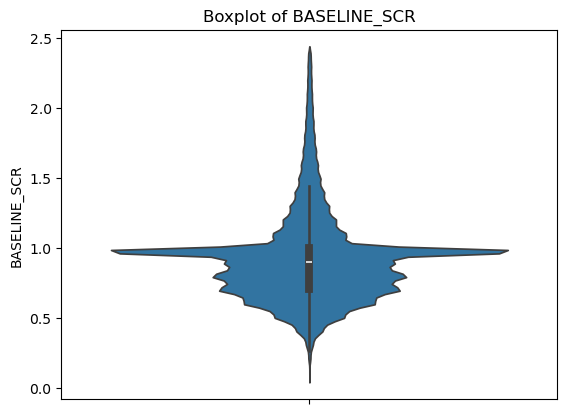

In [41]:
sns.violinplot(y=onset_df_final['BASELINE_SCR'])
plt.title('Boxplot of BASELINE_SCR')
plt.ylabel('BASELINE_SCR')
plt.show()

# Prepare for Labeling AKI Stages

In [42]:
# Append Baseline SCr to Complete SCr Dataframe
SCr_complete_df = SCr_complete_df.merge(onset_df_final[pat_id_cols + ['BASELINE_SCR']], how = 'left', on = pat_id_cols)
# because we drop some rows in onset_df_final, we need to drop corresponding rows in SCr_complete_df
SCr_complete_df = SCr_complete_df.dropna(subset=['BASELINE_SCR'])

In [43]:
# we only care about SCr measurements within hospitalization, thus we filter out history records
SCr_complete_df = SCr_complete_df[(SCr_complete_df.SPECIMEN_DATE >= SCr_complete_df.ADMIT_DATE) & \
    (SCr_complete_df.SPECIMEN_DATE <= SCr_complete_df.DISCHARGE_DATE)]

In [44]:
# sort SCr based on patent ids and specimen time
SCr_complete_df = SCr_complete_df.sort_values(pat_id_cols + ['SPECIMEN_DATE']).reset_index(drop=True)

In [45]:
# drop dups based on all columns
SCr_complete_df = SCr_complete_df.drop_duplicates()

The Kidney Disease: Improving Global Outcomes (KDIGO) clinical practice guidelines for acute kidney injury (AKI) define three stages based on serum creatinine levels and urine output:  
(1) Stage 1  
Serum creatinine increases by at least 0.3 mg/dL within 48 hours, or increases to 1.5–1.9 times baseline within 7 days.  
(2) Stage 2  
Serum creatinine increases to 2.0–2.9 times baseline.  
(3) Stage 3  
Serum creatinine increases to 3.0 or more times baseline, or increases to at least 4.0 mg/dL.  
 

# Label AKI Stage 1

In [46]:
# get the max SCr increment within past 2 days
def calculate_max_diff(group: pd.DataFrame) -> pd.DataFrame:
    max_diffs = []
    for index, row in group.iterrows():
        # past 2 days records
        past_2_days = group[(group['SPECIMEN_DATE'] >= row['SPECIMEN_DATE'] - pd.Timedelta(days=2)) & \
            (group['SPECIMEN_DATE'] < row['SPECIMEN_DATE'])]
        # if there are records within past 2 days
        if not past_2_days.empty:
            # get the max diffierence within past 2 days
            diffs = row['RESULT_NUM'] - past_2_days['RESULT_NUM']
            max_diff = diffs.max()
        else:
            max_diff = pd.NA
        max_diffs.append(max_diff)
    group['TWO_DAY_MAX_DIFF'] = max_diffs
    return group

In [47]:
# Group the DataFrame by patient ID columns
encounter_grouped = SCr_complete_df.groupby(pat_id_cols)
# Get the groups
groups = [group for _, group in encounter_grouped]
# Apply calculate_max_diff to each group
with Pool(cpu_count()) as p:
    result_groups = list(tqdm(p.imap(calculate_max_diff, groups), total=len(groups), 
                              desc="Calculating SCr Differences for AKI-1"))
# Combine the result groups back into a single DataFrame
SCr_complete_df = pd.concat(result_groups)

Calculating SCr Differences for AKI-1: 100%|██████████| 853621/853621 [09:53<00:00, 1438.49it/s] 


In [48]:
#here we get the cumulative max measurements within each group for labeling AKI-1 (prepares for AKI-1 label)
SCr_complete_df['CUMMAX_RESULT_NUM'] = SCr_complete_df.groupby(pat_id_cols)['RESULT_NUM'].cummax()
# reset index
SCr_complete_df = SCr_complete_df.reset_index(drop=True)

In [49]:
#AKI stage 1 definition part 1, absolute increment of 0.3 within 48 hours
condition1 = (SCr_complete_df['TWO_DAY_MAX_DIFF'] >= 0.3)
# the hidden conidtion is that even though condition 3 is satisfied it should not trigger AKI-2 or AKI-3 definition
hidden_condition1 = (SCr_complete_df['RESULT_NUM'] < 2.0 * SCr_complete_df['BASELINE_SCR'])
hidden_condition2 = (SCr_complete_df['RESULT_NUM'] < 4.0)
#AKI stage 1 definition part 2, fold increment
condition2 = (SCr_complete_df['RESULT_NUM'] >= 1.5 * SCr_complete_df['BASELINE_SCR']) & \
(SCr_complete_df['RESULT_NUM'] < 2.0 * SCr_complete_df['BASELINE_SCR'])
#we require that onset src should be the max value until that time, so that higher stage will overwrite lower stage
condition3 = (SCr_complete_df['RESULT_NUM'] == SCr_complete_df['CUMMAX_RESULT_NUM'])

In [50]:
# all the conditions should be met for AKI-1
AKI_1 = SCr_complete_df[(condition1 & condition3 & hidden_condition1 & hidden_condition2) | \
    (condition2 & condition3 )].copy(deep = True)
# take the first specimen date as the AKI-1 onset date
AKI_1 = AKI_1.groupby(pat_id_cols).first().reset_index().copy(deep = True)
AKI_1.rename(columns = {'SPECIMEN_DATE': 'AKI1_ONSET'}, inplace = True)
# merge back AKI-1 onset date
SCr_complete_df = SCr_complete_df.merge(AKI_1[pat_id_cols + ['AKI1_ONSET']], on=pat_id_cols, how='left')

# Label AKI Stage 2 

In [51]:
# AKI stage 2 definition part 1, absolute increment of 2 within 48 hours
condition4 = (SCr_complete_df['RESULT_NUM'] >= 2.0 * SCr_complete_df['BASELINE_SCR']) & \
    (SCr_complete_df['RESULT_NUM'] < 3.0 * SCr_complete_df['BASELINE_SCR'])

In [52]:
# all the conditions should be met for AKI-2, including not triggering AKI-3 definition of SCr > 4
AKI_2 = SCr_complete_df[condition4 & condition3 & hidden_condition2]
# take the first specimen date as the AKI-2 onset date
AKI_2 = AKI_2.groupby(pat_id_cols).first().reset_index().copy(deep = True)
# rename the column
AKI_2.rename(columns = {'SPECIMEN_DATE': 'AKI2_ONSET'}, inplace = True)
# merge back AKI-2 onset date
SCr_complete_df = SCr_complete_df.merge(AKI_2[pat_id_cols + ['AKI2_ONSET']], on=pat_id_cols, how='left')

# Label AKI Stage 3

In [53]:
# AKI-3 definition part 1, 3-fold SCr increment
condition5 = (SCr_complete_df['RESULT_NUM'] >= 3.0 * SCr_complete_df['BASELINE_SCR'])
# AKI-3 definition part 2, abusolute value >= 4.0
condition6 = (SCr_complete_df['RESULT_NUM'] >= 4.0)

In [54]:
# all the conditions should be met for AKI-3
AKI_3 = SCr_complete_df[(condition5 | condition6) & condition3]
# take the first specimen date as the AKI-3 onset date
AKI_3 = AKI_3.groupby(pat_id_cols).first().reset_index().copy(deep = True)
# rename the column
AKI_3.rename(columns = {'SPECIMEN_DATE': 'AKI3_ONSET'}, inplace = True)
# merge back AKI-3 onset date
SCr_complete_df = SCr_complete_df.merge(AKI_3[pat_id_cols + ['AKI3_ONSET']], on=pat_id_cols, how='left')

# Process the Dataframe before Saving

In [55]:
# one enconter only have one AKI-1/2/3 onset date, thus we can drop duplicates
SCr_complete_df_temp = SCr_complete_df[pat_id_cols + ['AKI1_ONSET', 'AKI2_ONSET', 'AKI3_ONSET']].copy(deep = True)
SCr_complete_df_temp = SCr_complete_df_temp.drop_duplicates(pat_id_cols)

In [56]:
# merge AKI-1/2/3 onset date back to onset_df_final
onset_df_final = onset_df_final.merge(SCr_complete_df_temp, on = pat_id_cols, how = 'left')
# label AKI onset as binary class
onset_df_final['AKI_ONSET_LABEL'] = np.where(
    onset_df_final['AKI1_ONSET'].notna() | onset_df_final['AKI2_ONSET'].notna() | onset_df_final['AKI3_ONSET'].notna(), 
    True, 
    False
)

In [57]:
onset_df_final.AKI_ONSET_LABEL.mean()

np.float64(0.23374855784153534)

In [58]:
# check AKI2_ONSET and AKI1_ONSET
condition1 = onset_df_final[(onset_df_final['AKI3_ONSET'].notna()) & (onset_df_final['AKI2_ONSET'].notna())]
assert (condition1['AKI3_ONSET'] >= condition1['AKI2_ONSET']).all(), "AKI3_ONSET should be greater than or equal to AKI2_ONSET"

# check AKI2_ONSET and AKI1_ONSET
condition2 = onset_df_final[(onset_df_final['AKI2_ONSET'].notna()) & (onset_df_final['AKI1_ONSET'].notna())]
assert (condition2['AKI2_ONSET'] >= condition2['AKI1_ONSET']).all(), "AKI2_ONSET should be greater than or equal to AKI1_ONSET"

# check AKI3_ONSET and AKI1_ONSET
condition3 = onset_df_final[(onset_df_final['AKI3_ONSET'].notna()) & (onset_df_final['AKI1_ONSET'].notna())]
assert (condition3['AKI3_ONSET'] >= condition3['AKI1_ONSET']).all(), "AKI3_ONSET should be greater than or equal to AKI1_ONSET"

print("All checks passed.")

All checks passed.


In [59]:
dup_check(onset_df_final, pat_id_cols)

# of rows before dropping dups:  853755
# of rows after dropping dups:  853755


In [60]:
onset_df_final.to_csv('/blue/yonghui.wu/lideyi/AKI_GNN/raw_data/onset_df.csv', index = False)